In [1]:
library(tidyverse)
library(cowplot)
library(DataExplorer)
library(skimr)
library(GGally)
library(funModeling)
library(tidyquant)
library(reshape2)
library(corrr)
library(recipes)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: Hmisc
Loading required package: lattice
Load

In [2]:
df <- read_csv('telco_customer_churn.csv', col_types = cols(customerID = col_skip()))
df <- df %>% 
        mutate_if(is.character, as_factor) %>% 
        mutate(Churn = Churn %>% fct_relevel('Yes'))
glimpse(df)

Observations: 7,043
Variables: 20
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fema…
$ SeniorCitizen    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Y…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, N…
$ tenure           <dbl> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, …
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes, …
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Yes,…
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber …
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No…
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No i…
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No i…
$ TechSupport      <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No int…
$ StreamingTV     

In [3]:
skim(df)

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             7043  
Number of columns          20    
_______________________          
Column type frequency:           
  factor                   16    
  numeric                  4     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
   skim_variable    n_missing complete_rate ordered n_unique
 1 gender                   0             1 FALSE          2
 2 Partner                  0             1 FALSE          2
 3 Dependents               0             1 FALSE          2
 4 PhoneService             0             1 FALSE          2
 5 MultipleLines            0             1 FALSE          3
 6 InternetService          0             1 FALSE          3
 7 OnlineSecurity           0             1 FALSE          3
 8 OnlineBackup             0             1 FALSE

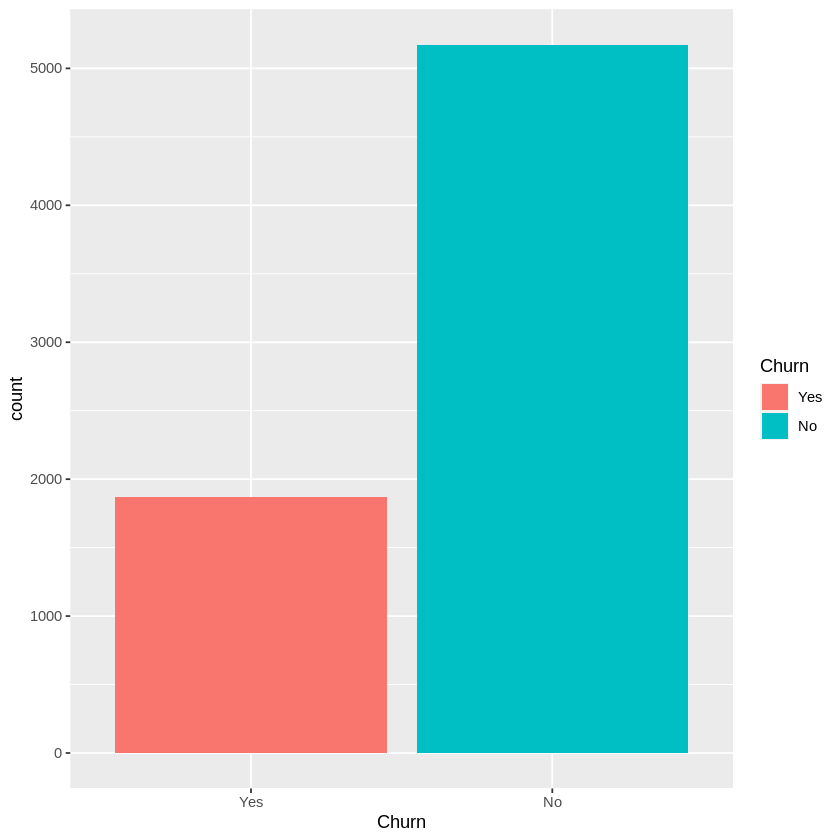

In [4]:
df %>% 
    ggplot(aes(x = Churn, fill = Churn)) +
    geom_bar()

#### It is not very imbalanced. So we dont need to use techniques like SMOTE.

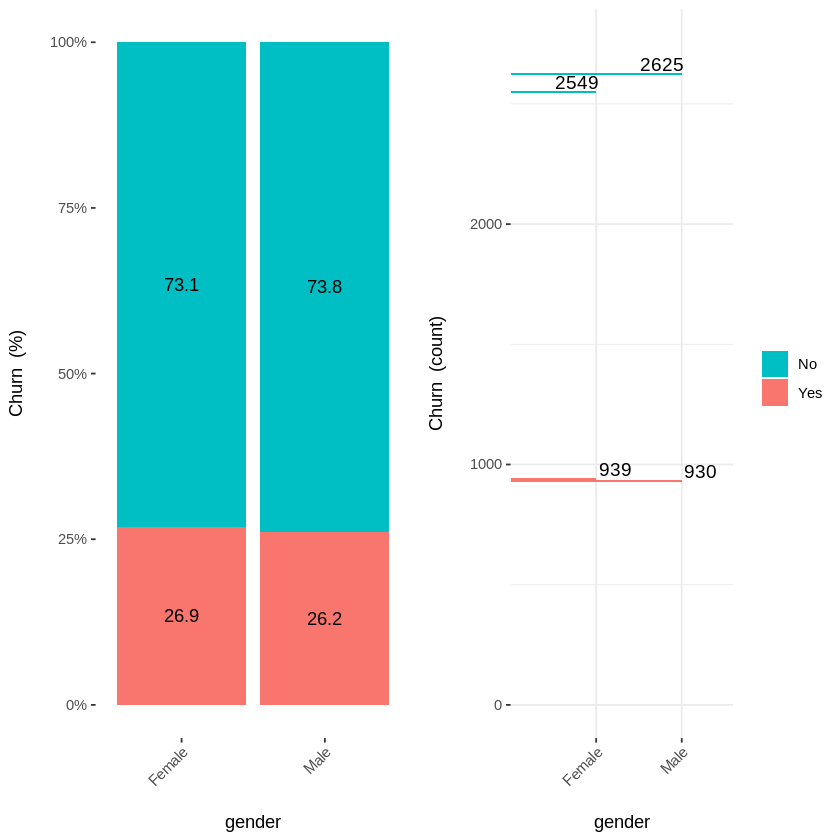

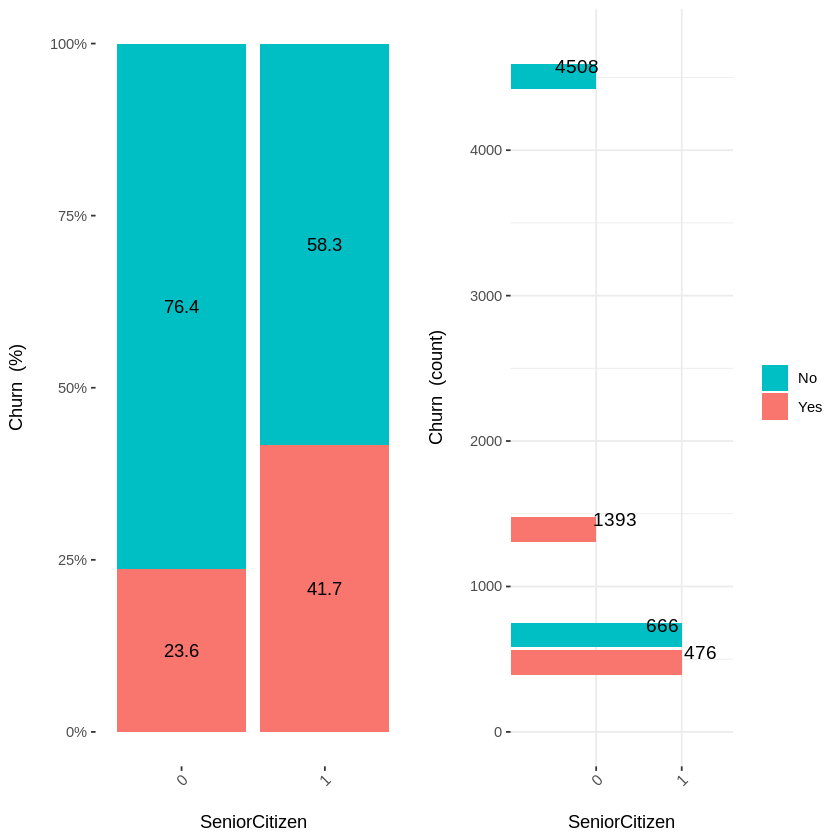

Plotting transformed variable 'tenure' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'


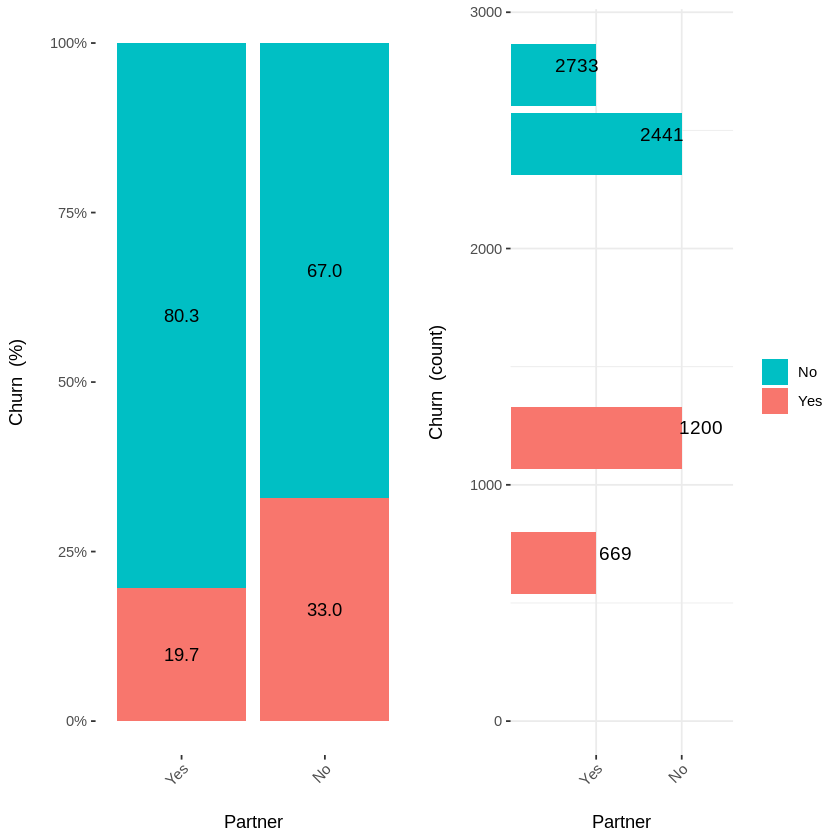

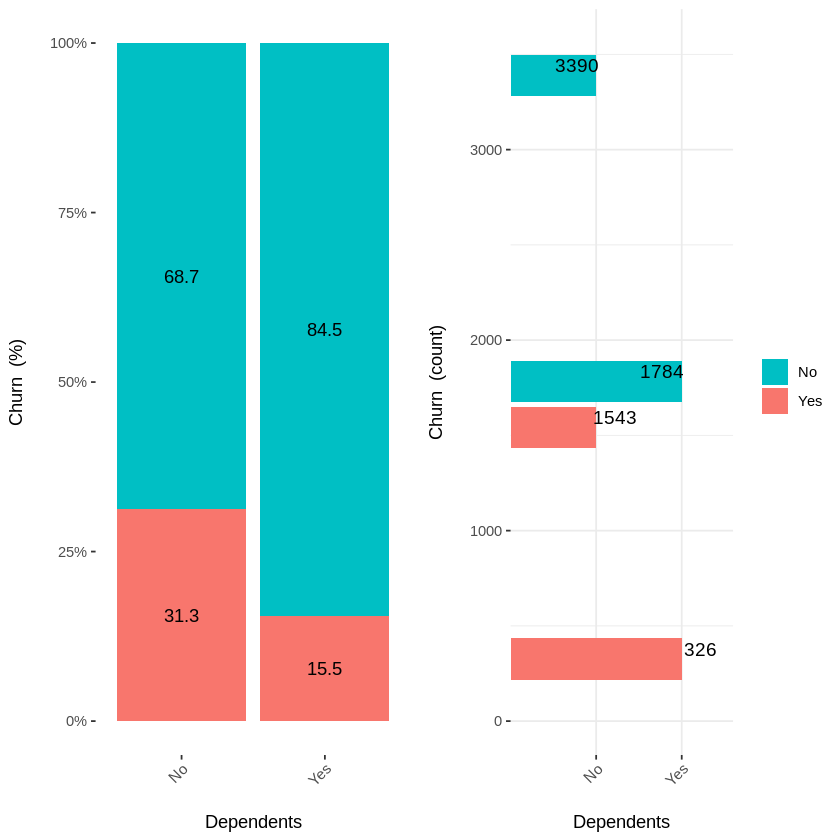

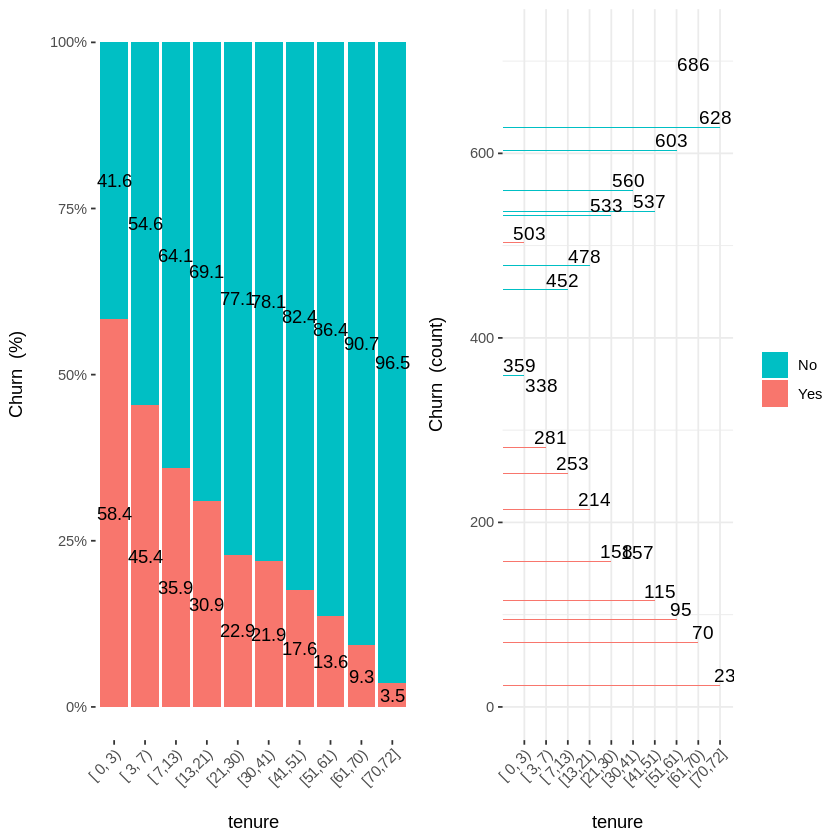

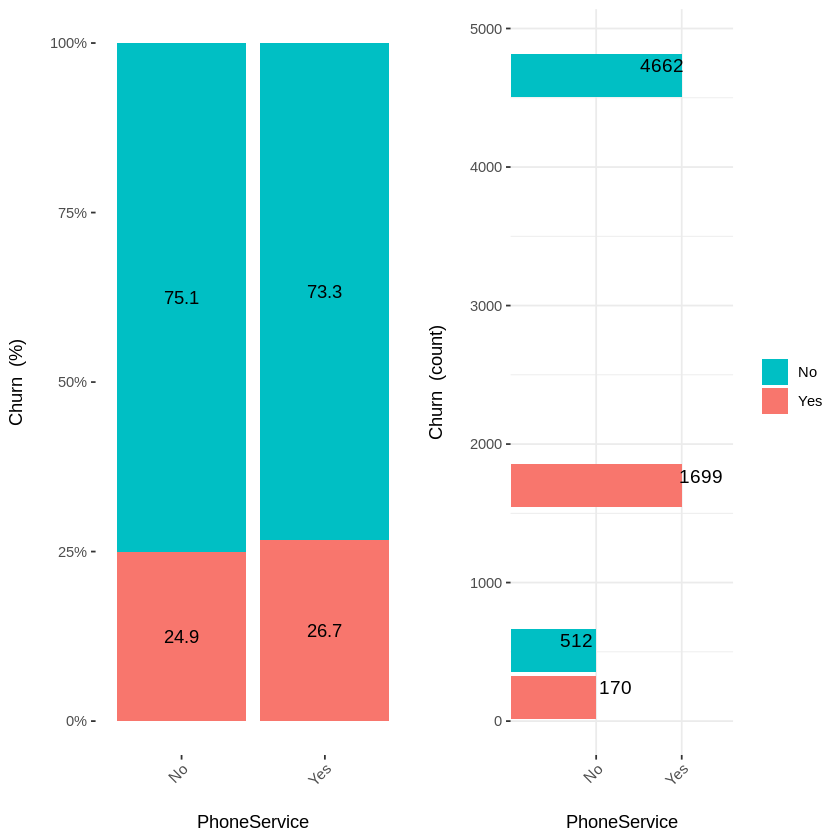

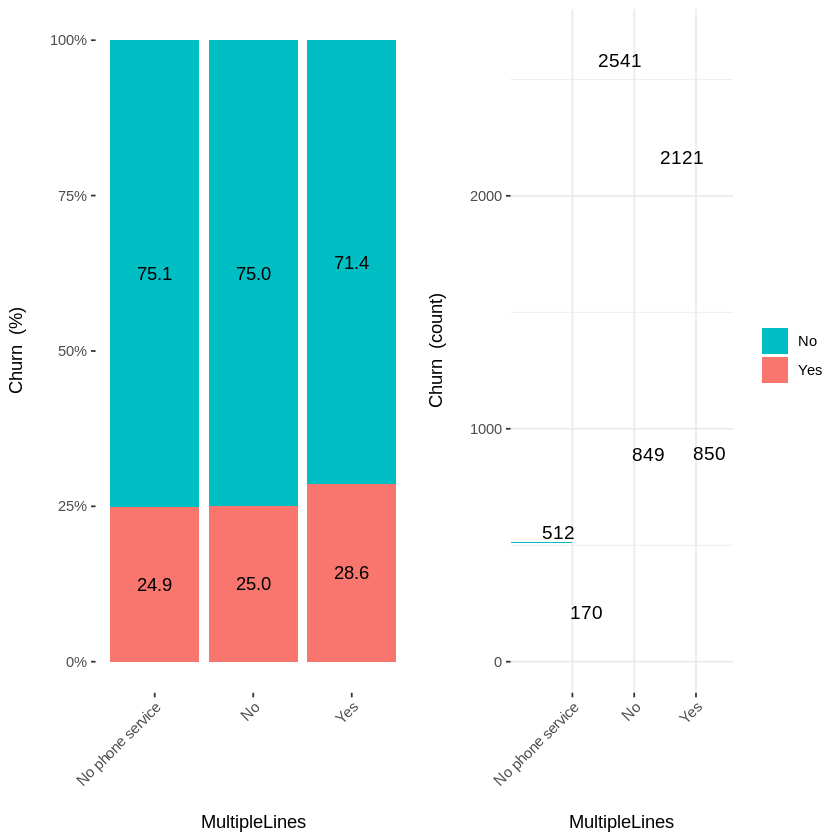

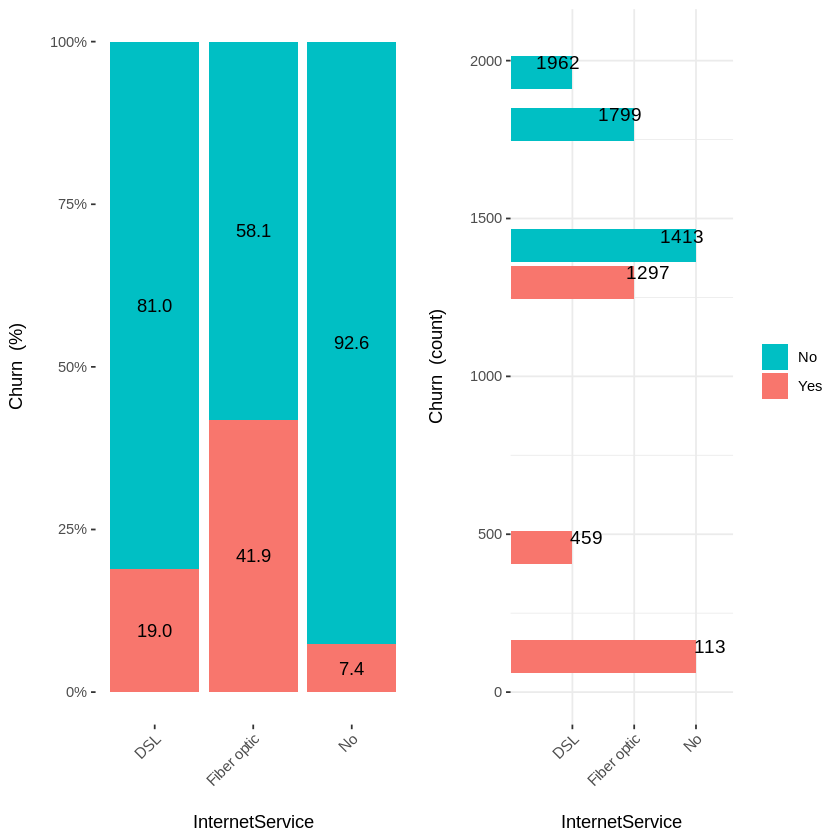

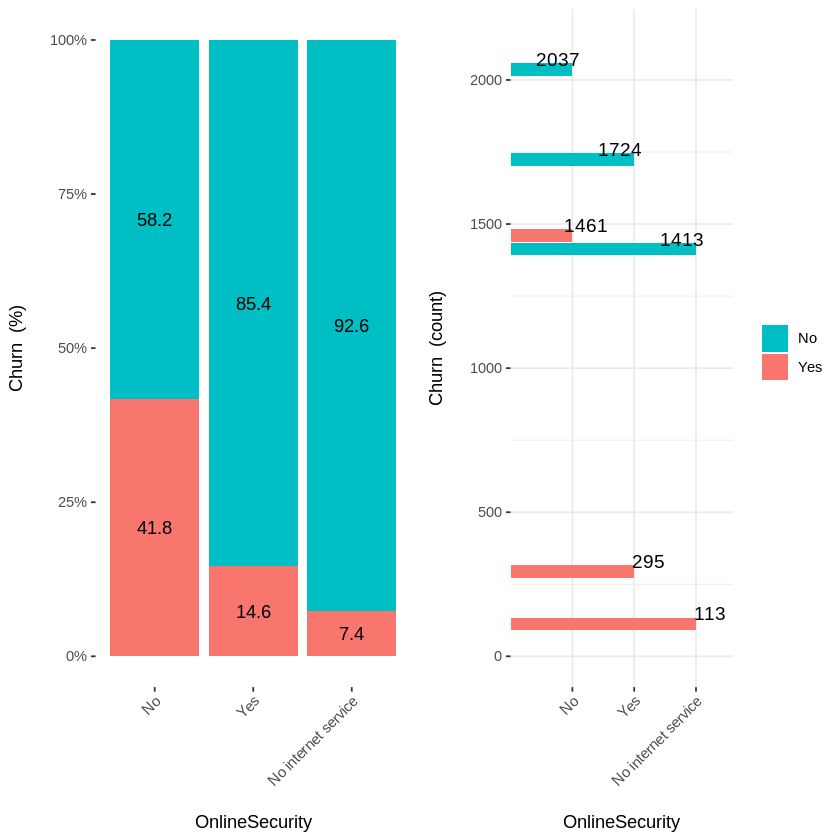

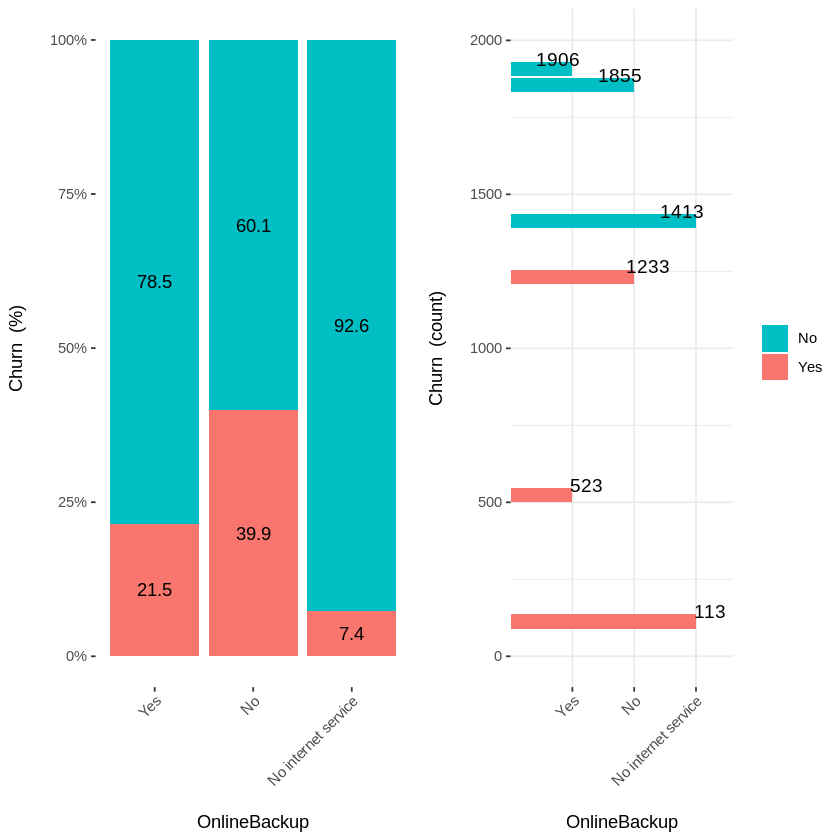

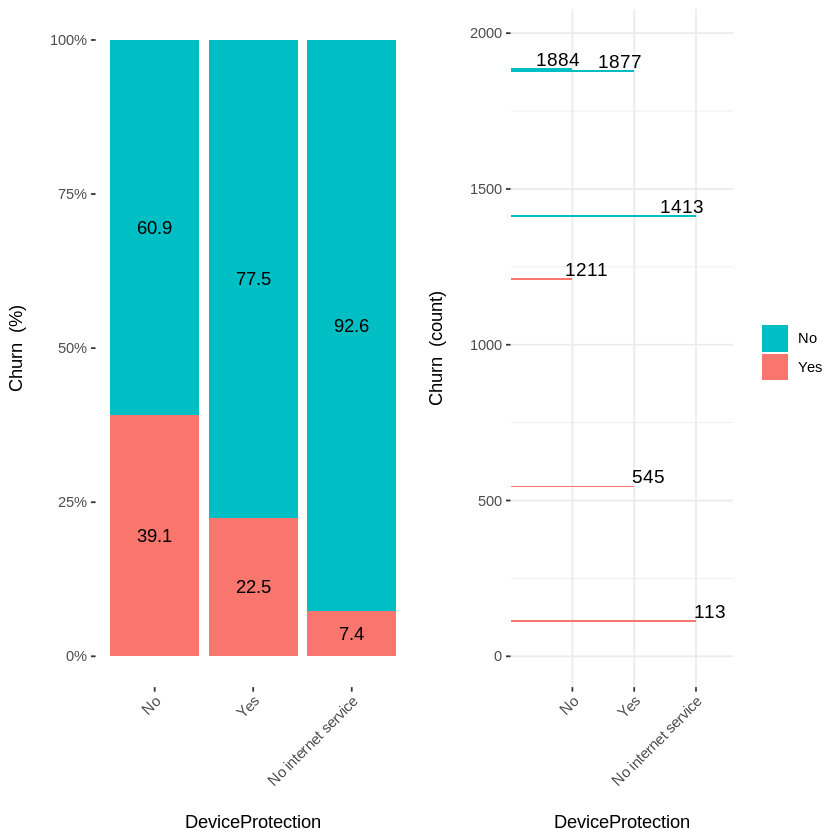

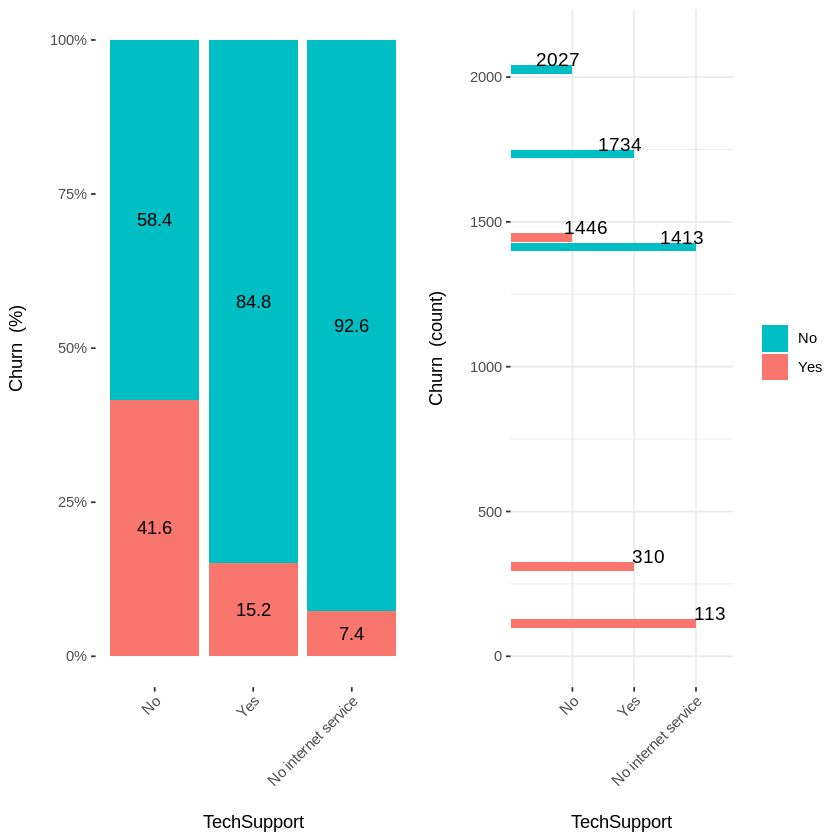

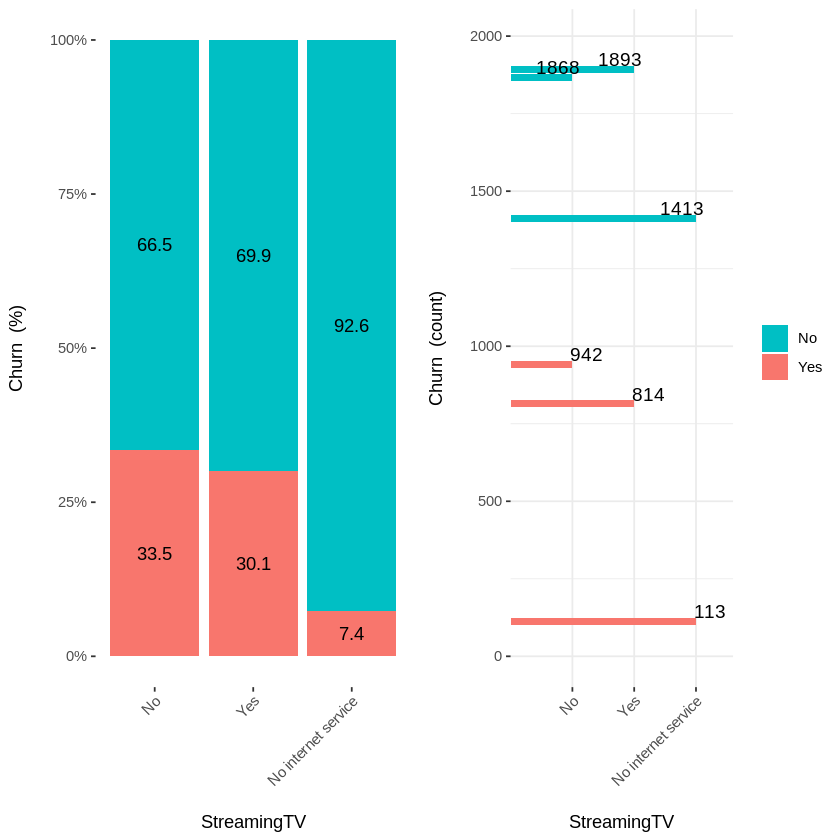

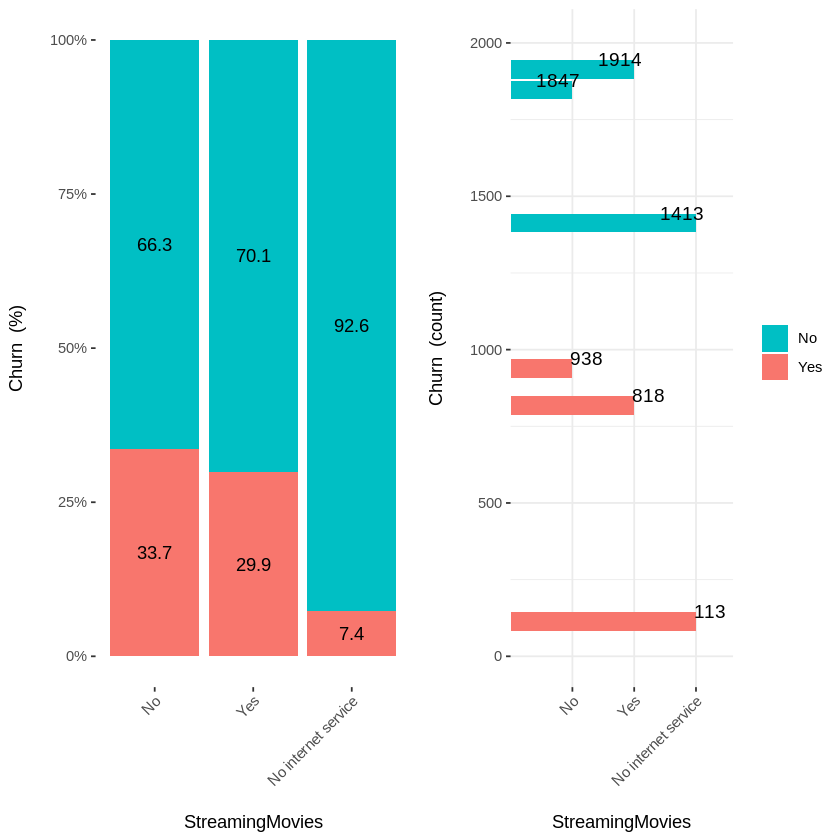

Warning message:
“Removed 1 rows containing missing values (geom_bar).”

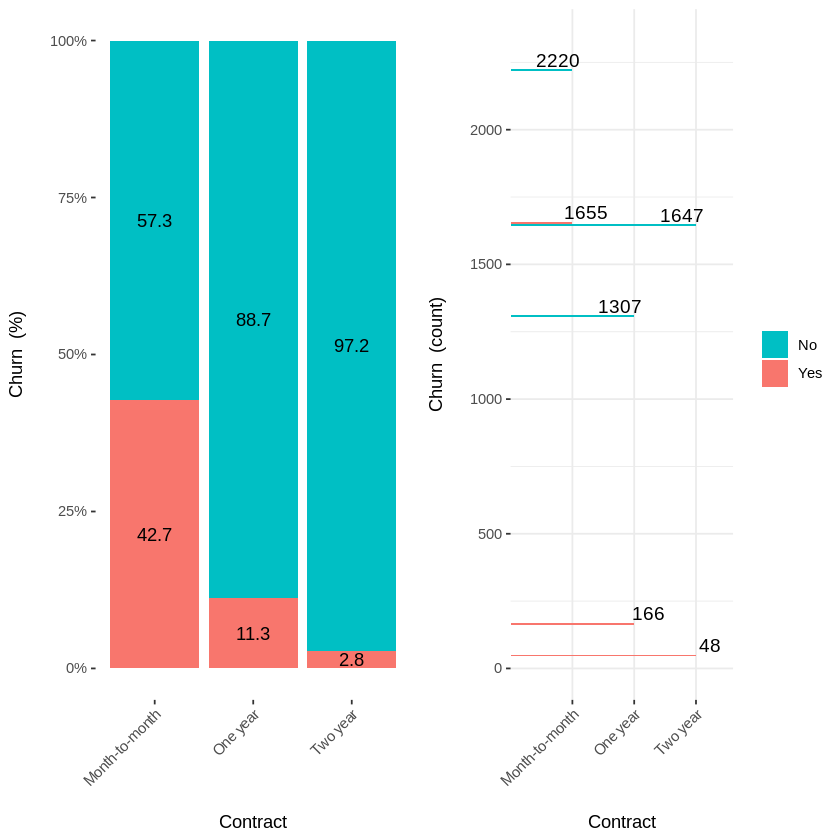

Plotting transformed variable 'MonthlyCharges' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'


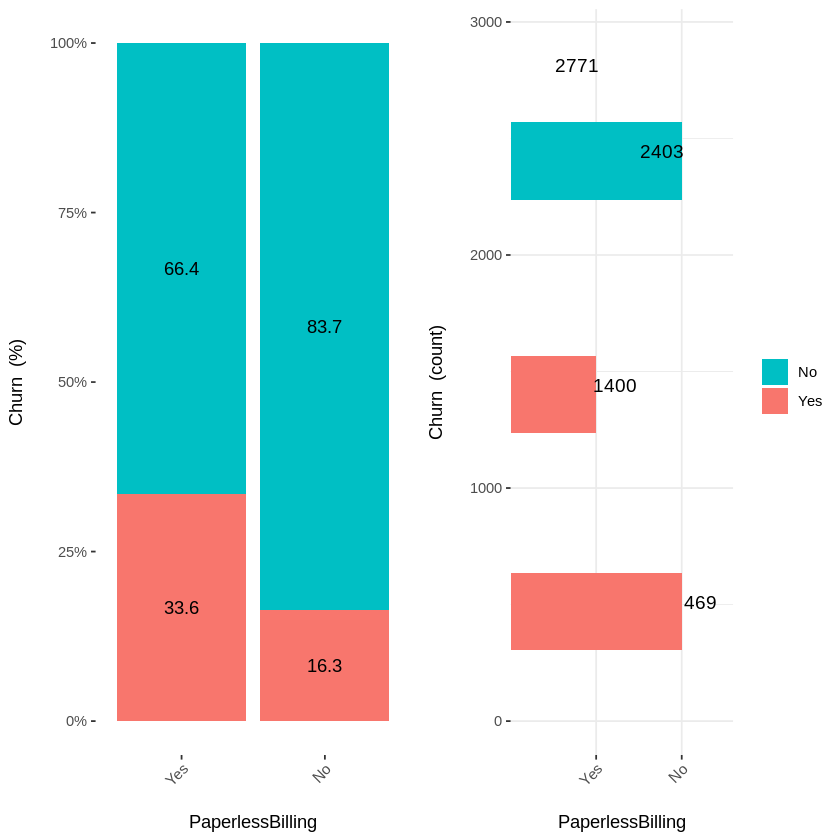

Plotting transformed variable 'TotalCharges' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'
Warning message:
“Factor `varInput` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `varInput` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `varInput` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `varInput` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `varInput` contains implicit NA, consider using `forcats::fct_explicit_na`”

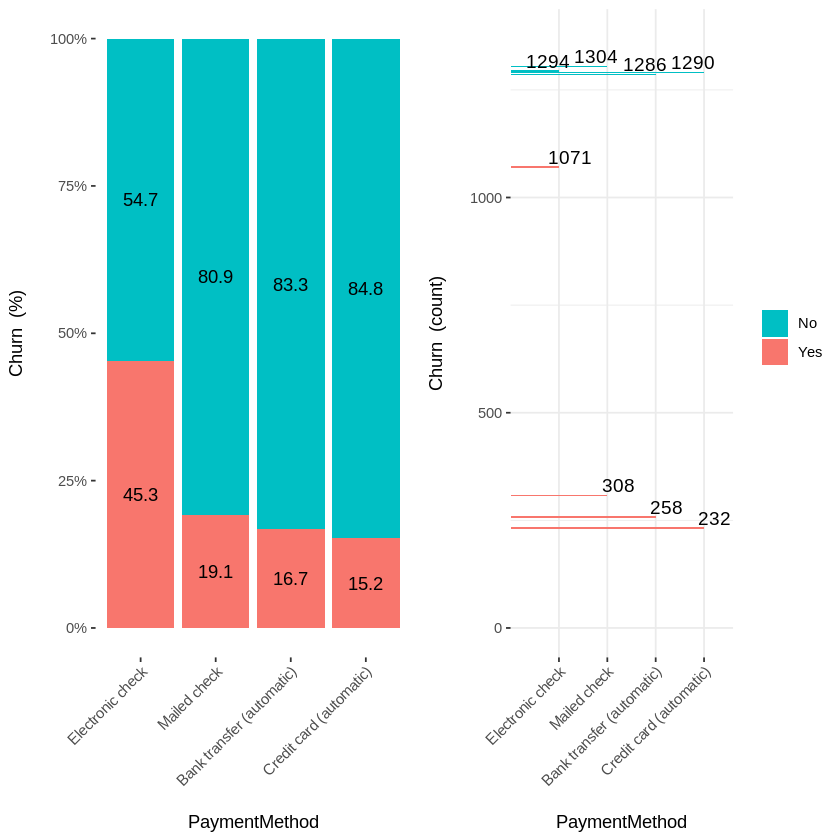

Warning message:
“Removed 1 rows containing missing values (geom_bar).”

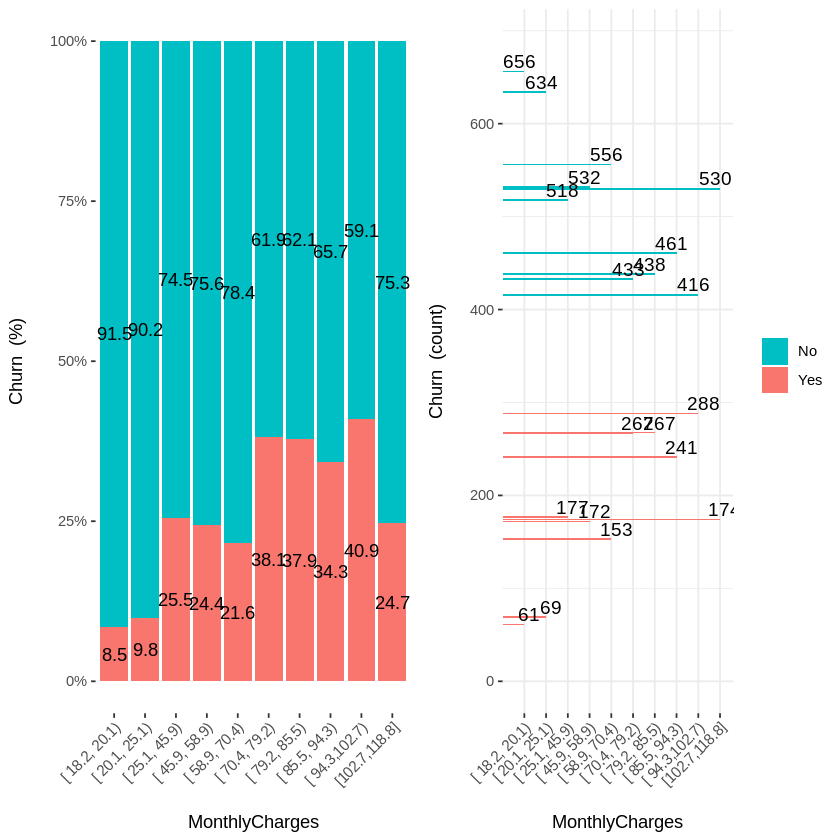

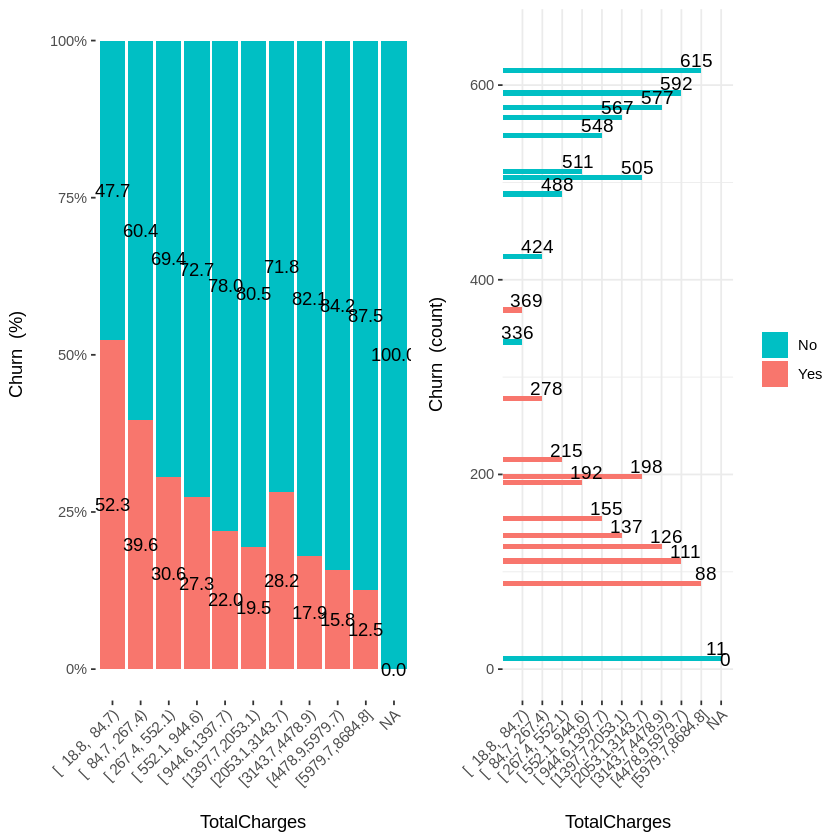

In [5]:
cross_plot(data=df, target="Churn")

### Factors with which churn increases -

* Low values of tenure (New customers)

* High monthly charges

* Month to month contract

* Purchased Fiber optic internet

* No online security

* No device protection 

* No tech support

* Electronic check payment

#### Lets take a closer look at the important features.
#### We will make a custom plotting function along with cowplot.

In [6]:
plot_func <- function(feature){
    
    feature <- enquo(feature)
    
    if (df %>% pull(!!feature) %>% is.numeric()){
        
        g <- df %>%
    select(!!feature, Churn) %>% 
    mutate(bins = cut(df %>% pull(!!feature), breaks = 9)) %>% 
    ggplot() +
    geom_bar(aes(x = bins, fill = Churn), position = position_fill(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = paste(quo_name(feature),' vs Churn'))
        
        
    }

    
    else{
        
        g <- df %>%
    select(!!feature, Churn) %>% 
    ggplot() +
    geom_bar(aes(x = !!feature, fill = Churn), position = position_fill(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = paste(quo_name(feature),' vs Churn'))
        
    }
    
    
           
    return(g)
    
}

In [7]:
p1 <- plot_func(tenure)
p2 <- plot_func(MonthlyCharges)
p3 <- plot_func(Contract)
p4 <- plot_func(InternetService)
p5 <- plot_func(OnlineSecurity)
p6 <- plot_func(DeviceProtection)
p7 <- plot_func(PaymentMethod)
p8 <- plot_func(TechSupport)

#### Let's use cowplot to combine multiple plots into one.

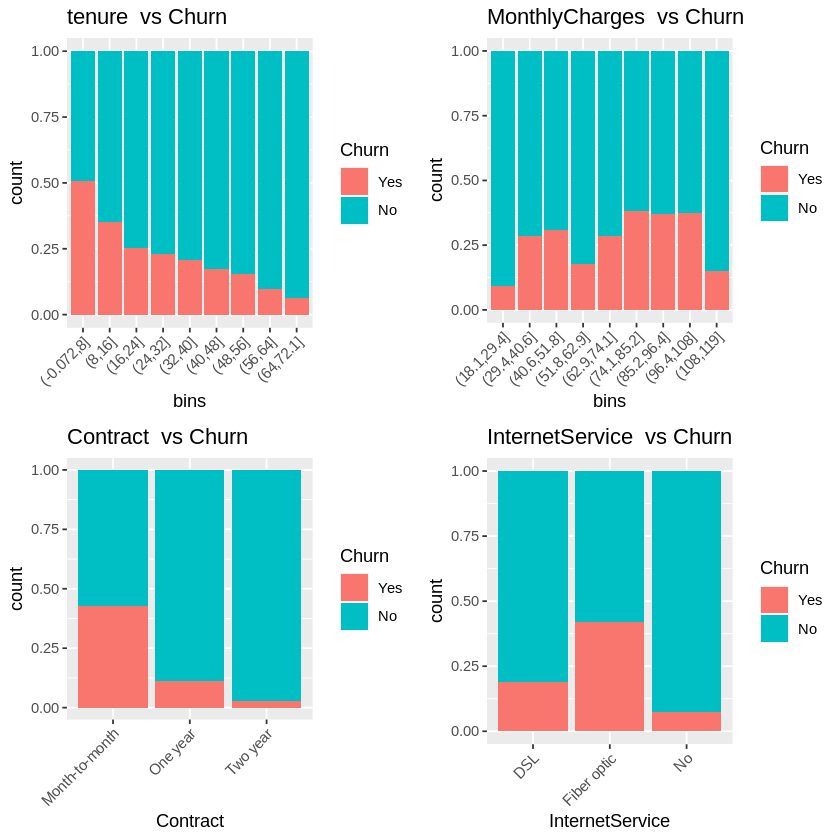

In [22]:
g1 <- plot_grid(p1,p2,p3,p4)
g1

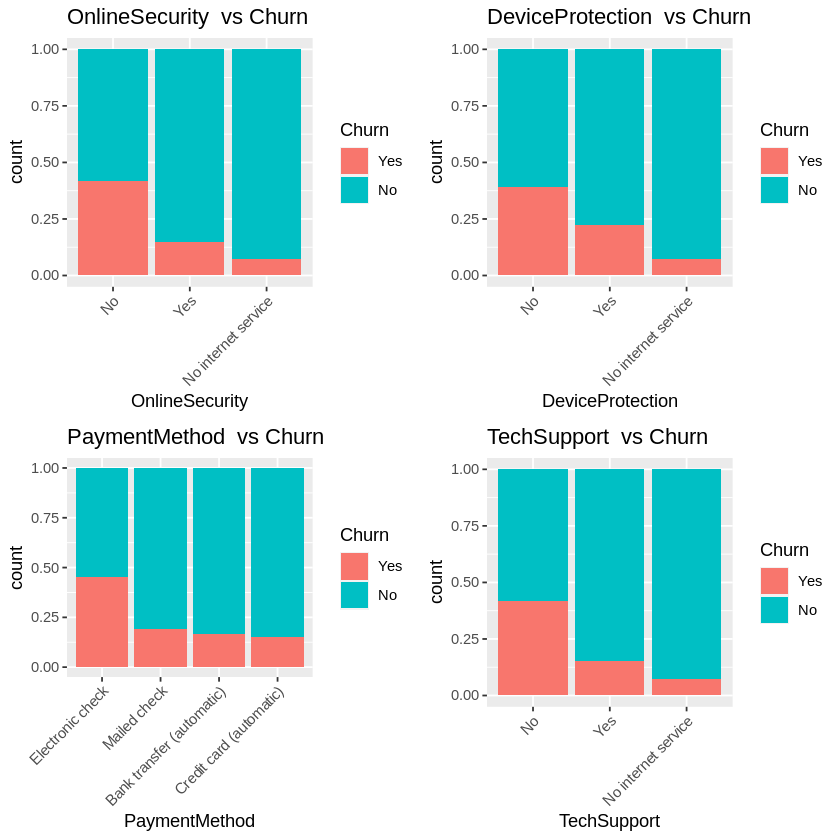

In [23]:
g2 <- plot_grid(p5,p6,p7,p8)
g2

In [25]:
# Lets save the plots
ggsave('grid1.png', g1)
ggsave('grid1.png', g2)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [10]:
corr_recipe <- df %>% 
    recipe(Churn ~ ., data = df) %>%
    step_knnimpute(TotalCharges) %>% 
    step_YeoJohnson(all_numeric()) %>%
    step_center(all_numeric()) %>% 
    step_scale(all_numeric()) %>%
    step_mutate(SeniorCitizen = SeniorCitizen %>% as.numeric()) %>% 
    step_dummy(all_nominal(), -Churn, one_hot = T) %>% 
    step_mutate(Churn = as.numeric(Churn == 'Yes'))

In [11]:
df_processed <- corr_recipe %>%
    prep() %>% 
    bake(df)
df_processed %>% glimpse()

Observations: 7,043
Variables: 46
$ SeniorCitizen                           <dbl> -0.4398853, -0.4398853, -0.43…
$ tenure                                  <dbl> -1.64422287, 0.29718222, -1.4…
$ MonthlyCharges                          <dbl> -1.1584589, -0.2394746, -0.34…
$ TotalCharges                            <dbl> -1.81029673, 0.25453584, -1.3…
$ Churn                                   <dbl> 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,…
$ gender_Female                           <dbl> 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,…
$ gender_Male                             <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Partner_Yes                             <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Partner_No                              <dbl> 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,…
$ Dependents_No                           <dbl> 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,…
$ Dependents_Yes                          <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,…
$ PhoneService_No                         <dbl> 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,…
$ PhoneService_Yes

In [12]:
col_names <- df_processed %>% colnames()
col_names %>% enframe

name,value
1,SeniorCitizen
2,tenure
3,MonthlyCharges
4,TotalCharges
5,Churn
6,gender_Female
7,gender_Male
8,Partner_Yes
9,Partner_No
10,Dependents_No


In [13]:
drop_cols <- col_names[c(6,9,10,12,14,15,19,21,22,23,25,27,28,30,31,32,34,35,37,39,42,44)]
drop_cols

[1] "gender_Female"                       
 [2] "Partner_No"                          
 [3] "Dependents_No"                       
 [4] "PhoneService_No"                     
 [5] "MultipleLines_No.phone.service"      
 [6] "MultipleLines_No"                    
 [7] "InternetService_No"                  
 [8] "OnlineSecurity_Yes"                  
 [9] "OnlineSecurity_No.internet.service"  
[10] "OnlineBackup_Yes"                    
[11] "OnlineBackup_No.internet.service"    
[12] "DeviceProtection_Yes"                
[13] "DeviceProtection_No.internet.service"
[14] "TechSupport_Yes"                     
[15] "TechSupport_No.internet.service"     
[16] "StreamingTV_No"                      
[17] "StreamingTV_No.internet.service"     
[18] "StreamingMovies_No"                  
[19] "StreamingMovies_No.internet.service" 
[20] "Contract_One.year"                   
[21] "PaperlessBilling_No"                 
[22] "PaymentMethod_Mailed.check"

#### These columns are redundant so we will drop them.

In [14]:
df_processed <- df_processed %>% select(-drop_cols)

In [15]:
correlate(df_processed) %>%
    shave() %>% 
    stretch() %>% 
    filter(!is.na(r)) %>% 
    arrange(desc(abs(r))) %>% 
    slice(1:10)


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'



x,y,r
tenure,TotalCharges,0.8985782
MonthlyCharges,InternetService_Fiber.optic,0.7838815
InternetService_DSL,InternetService_Fiber.optic,-0.6409872
tenure,Contract_Month.to.month,-0.6323578
MonthlyCharges,StreamingTV_Yes,0.6269692
MonthlyCharges,StreamingMovies_Yes,0.6248919
Contract_Month.to.month,Contract_Two.year,-0.6226334
MonthlyCharges,TotalCharges,0.6163811
StreamingTV_Yes,StreamingMovies_Yes,0.5330938
tenure,Contract_Two.year,0.5091687


#### We can get monthly charges by looking at the services which the customer uses.
#### We can get tenure from monthly charges and total charges.
#### So lets drop monthly charges and total charges.

In [16]:
drop_cols_2 <- append(drop_cols, c('MonthlyCharges', 'TotalCharges'))

# Lets modify the recipe
corr_recipe_2 <- corr_recipe %>% 
                step_rm(drop_cols_2) 

df_processed <- corr_recipe_2 %>%
    prep() %>% 
    bake(df)


In [17]:
# Save drop_cols_2
saveRDS(drop_cols_2, file = "drop_cols_2.rds")

In [18]:
df_processed %>% glimpse

Observations: 7,043
Variables: 22
$ SeniorCitizen                           <dbl> -0.4398853, -0.4398853, -0.43…
$ tenure                                  <dbl> -1.64422287, 0.29718222, -1.4…
$ Churn                                   <dbl> 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,…
$ gender_Male                             <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Partner_Yes                             <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Dependents_Yes                          <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,…
$ PhoneService_Yes                        <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,…
$ MultipleLines_Yes                       <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,…
$ InternetService_DSL                     <dbl> 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,…
$ InternetService_Fiber.optic             <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,…
$ OnlineSecurity_No                       <dbl> 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,…
$ OnlineBackup_No                         <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,…
$ DeviceProtection

In [19]:
correlate(df_processed) %>% 
    shave() %>% 
    stretch() %>% 
    arrange(desc(abs(r))) %>% 
    slice(1:10)


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'



x,y,r
InternetService_DSL,InternetService_Fiber.optic,-0.6409872
tenure,Contract_Month.to.month,-0.6323578
Contract_Month.to.month,Contract_Two.year,-0.6226334
StreamingTV_Yes,StreamingMovies_Yes,0.5330938
tenure,Contract_Two.year,0.5091687
OnlineSecurity_No,TechSupport_No,0.4703593
Partner_Yes,Dependents_Yes,0.4526763
PhoneService_Yes,InternetService_DSL,-0.4524255
TechSupport_No,Contract_Month.to.month,0.4391098
DeviceProtection_No,TechSupport_No,0.4198921


In [20]:
cor_tbl <- correlate(df_processed) %>% 
    stretch() %>% 
    filter(x == 'Churn', y != 'Churn')

cor_tbl


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'



x,y,r
Churn,SeniorCitizen,0.150889328
Churn,tenure,-0.369979817
Churn,gender_Male,-0.008612095
Churn,Partner_Yes,-0.150447545
Churn,Dependents_Yes,-0.164221402
Churn,PhoneService_Yes,0.011941980
Churn,MultipleLines_Yes,0.040102128
Churn,InternetService_DSL,-0.124213824
Churn,InternetService_Fiber.optic,0.308019745
Churn,OnlineSecurity_No,0.342636800


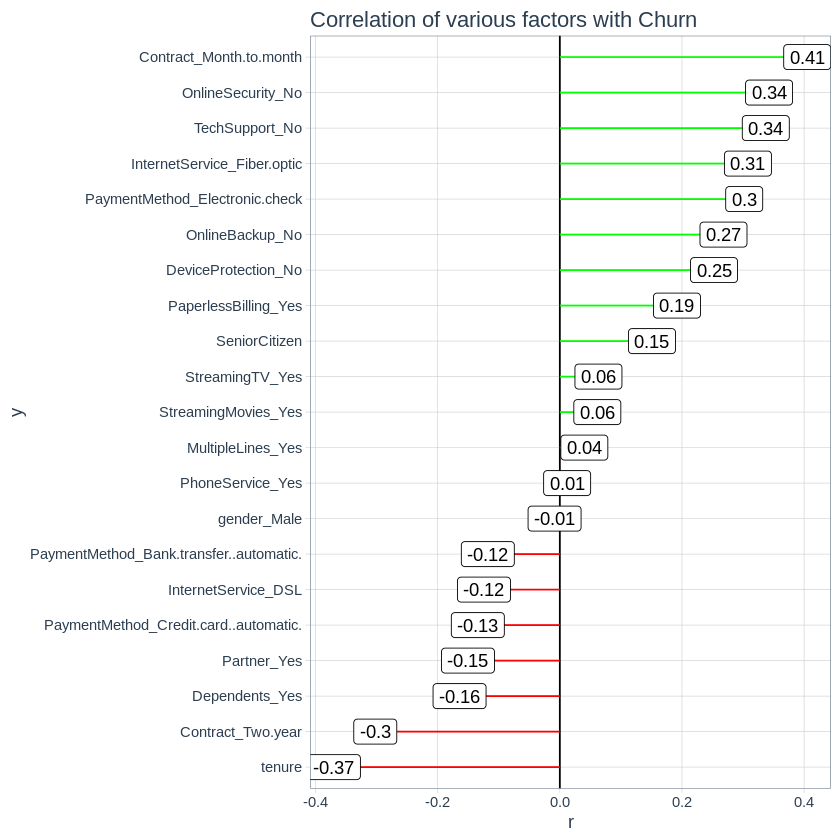

In [26]:
corr_plot <- cor_tbl %>% 
    mutate(y = y %>% as_factor() %>% fct_reorder(r)) %>% 
    ggplot(aes(r, y)) +
    geom_vline(xintercept = 0) +
    geom_segment(aes(xend = 0, yend = y), color = ifelse(cor_tbl$r >= 0 , 'green', 'red')) +
    geom_label(aes(label = round(r,2))) +
    theme_tq()+
    labs(title = 'Correlation of various factors with Churn')

corr_plot

### Factors with which churn increases -
* Month to month contract
* No online security.
* Fiber optic internet users
* No tech support
* Electronic check payment method
* No online backup
***
### Factors with which churn decreases -
* High tenure
* Two year contract
* No internet service


In [27]:
# Lets save the correlation plot
ggsave('corr_plot.png', corr_plot)

Saving 6.67 x 6.67 in image
